In [ ]:
project_name = 'gan_image_generator'

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/quynhlecl/lung-cancer-x-ray"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shreyamali01
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/quynhlecl/lung-cancer-x-ray


100%|██████████| 2.28G/2.28G [00:20<00:00, 119MB/s]


In [ ]:
import os
import shutil
import hashlib

DATA_DIR = "/content/lung-cancer-x-ray"
TARGET_DIR = os.path.join(DATA_DIR, "images")
os.makedirs(TARGET_DIR, exist_ok=True)

# Find all Cancer folders
cancer_folders = []
for root, dirs, files in os.walk(DATA_DIR):
    if os.path.basename(root) == "Cancer":
        cancer_folders.append(root)

print("Cancer folders found:", len(cancer_folders))

# Copy unique images by content hash
seen_hashes = set()
count = 0

for folder in cancer_folders:
    for img in os.listdir(folder):
        src_path = os.path.join(folder, img)

        # compute hash
        with open(src_path, "rb") as f:
            img_hash = hashlib.md5(f.read()).hexdigest()

        # skip duplicates by content
        if img_hash in seen_hashes:
            continue

        seen_hashes.add(img_hash)

        # copy
        dst_path = os.path.join(TARGET_DIR, img)
        shutil.copy(src_path, dst_path)
        count += 1

print("Unique cancer images copied:", count)
print("Total images in images folder:", len(os.listdir(TARGET_DIR)))
print(os.listdir(TARGET_DIR)[:10])

Cancer folders found: 6
Unique cancer images copied: 4245
Total images in images folder: 4245
['train2_cancer78.jpeg', 'train2_cancer1616.jpeg', 'train2_cancer2814.jpeg', 'train2_cancer186.jpeg', 'train2_cancer3562.jpeg', 'train2_cancer3012.jpeg', 'train2_cancer154.jpeg', 'train2_cancer2105.jpeg', 'train2_cancer2163.jpeg', 'train2_cancer215.jpeg']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['train2_cancer78.jpeg', 'train2_cancer1616.jpeg', 'train2_cancer2814.jpeg', 'train2_cancer186.jpeg', 'train2_cancer3562.jpeg', 'train2_cancer3012.jpeg', 'train2_cancer154.jpeg', 'train2_cancer2105.jpeg', 'train2_cancer2163.jpeg', 'train2_cancer215.jpeg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

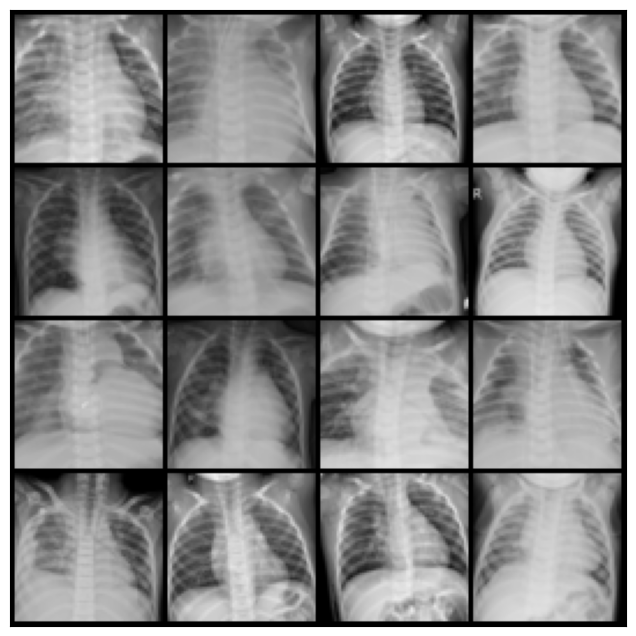

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


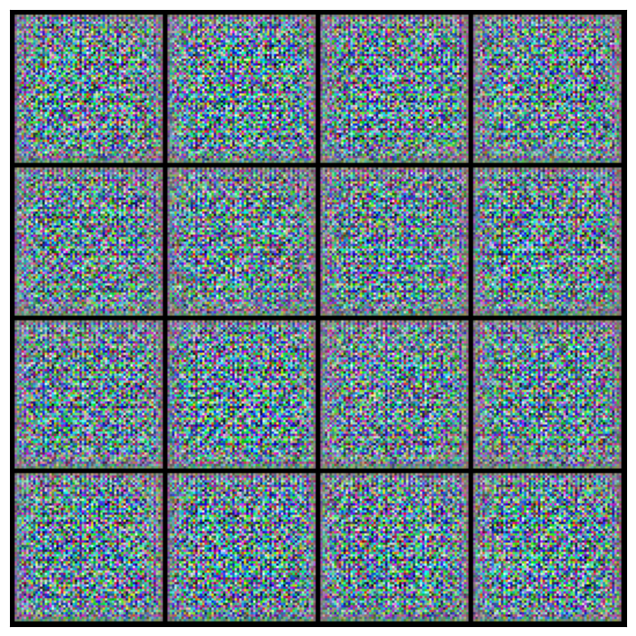

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


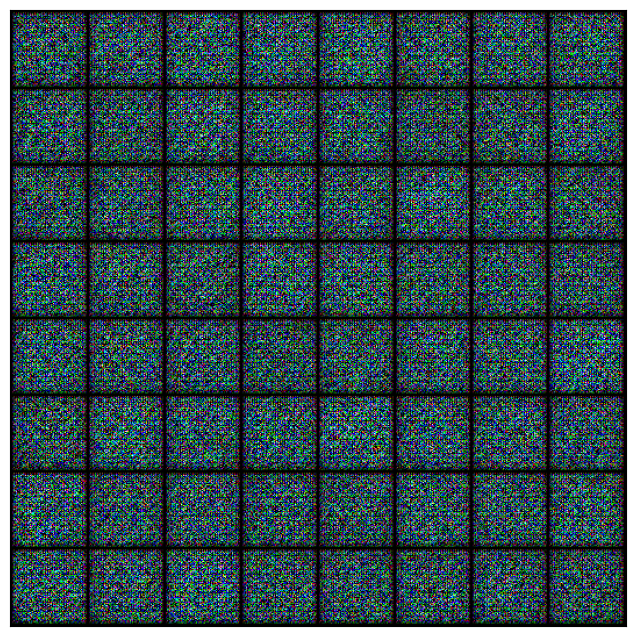

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 7.5177, loss_d: 0.0881, real_score: 0.9780, fake_score: 0.0561
Saving generated-images-0001.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 10.7678, loss_d: 2.6313, real_score: 0.9936, fake_score: 0.9179
Saving generated-images-0002.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 2.3868, loss_d: 0.3388, real_score: 0.8527, fake_score: 0.1432
Saving generated-images-0003.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 2.9131, loss_d: 0.5767, real_score: 0.7274, fake_score: 0.1998
Saving generated-images-0004.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.4914, loss_d: 0.3338, real_score: 0.8496, fake_score: 0.1402
Saving generated-images-0005.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 8.6988, loss_d: 2.4256, real_score: 0.9966, fake_score: 0.8840
Saving generated-images-0006.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.2149, loss_d: 0.1888, real_score: 0.8482, fake_score: 0.0106
Saving generated-images-0007.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 7.1914, loss_d: 0.5663, real_score: 0.9643, fake_score: 0.3838
Saving generated-images-0008.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.1420, loss_d: 0.3238, real_score: 0.8451, fake_score: 0.1258
Saving generated-images-0009.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.4433, loss_d: 0.6462, real_score: 0.9172, fake_score: 0.3861
Saving generated-images-0010.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.0947, loss_d: 0.2588, real_score: 0.8679, fake_score: 0.1017
Saving generated-images-0011.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.4347, loss_d: 0.4564, real_score: 0.6928, fake_score: 0.0414
Saving generated-images-0012.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.8037, loss_d: 0.4015, real_score: 0.8594, fake_score: 0.1884
Saving generated-images-0013.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.5486, loss_d: 0.1518, real_score: 0.9593, fake_score: 0.0995
Saving generated-images-0014.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.9650, loss_d: 0.2380, real_score: 0.8833, fake_score: 0.0982
Saving generated-images-0015.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.6954, loss_d: 0.5568, real_score: 0.9288, fake_score: 0.3547
Saving generated-images-0016.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.5449, loss_d: 0.4527, real_score: 0.8923, fake_score: 0.2548
Saving generated-images-0017.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.3810, loss_d: 0.1695, real_score: 0.9595, fake_score: 0.1134
Saving generated-images-0018.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.0439, loss_d: 0.3170, real_score: 0.7876, fake_score: 0.0512
Saving generated-images-0019.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.0230, loss_d: 0.1516, real_score: 0.9556, fake_score: 0.0967
Saving generated-images-0020.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 4.6320, loss_d: 2.4832, real_score: 0.1501, fake_score: 0.0006
Saving generated-images-0021.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.8944, loss_d: 0.1625, real_score: 0.9762, fake_score: 0.1181
Saving generated-images-0022.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.7231, loss_d: 0.0916, real_score: 0.9371, fake_score: 0.0173
Saving generated-images-0023.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 3.2111, loss_d: 0.1613, real_score: 0.8812, fake_score: 0.0282
Saving generated-images-0024.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.3838, loss_d: 0.2886, real_score: 0.7927, fake_score: 0.0113
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
from IPython.display import Image

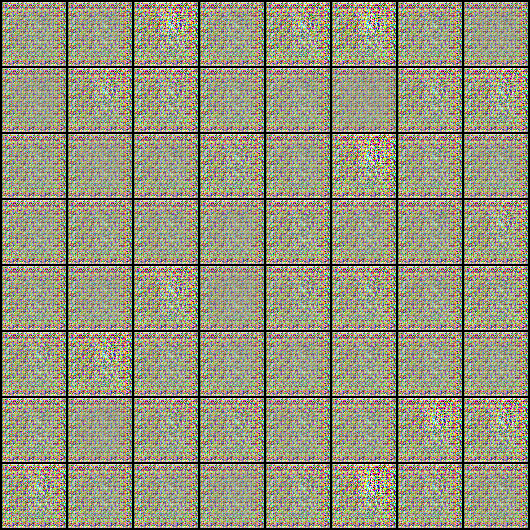

In [ ]:
Image('./generated/generated-images-0001.png')

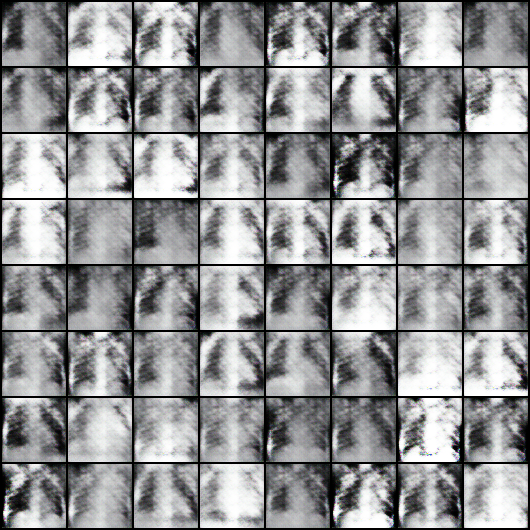

In [ ]:
Image('./generated/generated-images-0005.png')

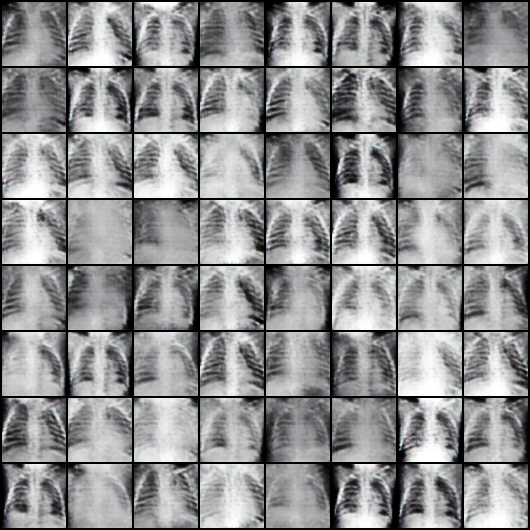

In [ ]:
Image('./generated/generated-images-0010.png')

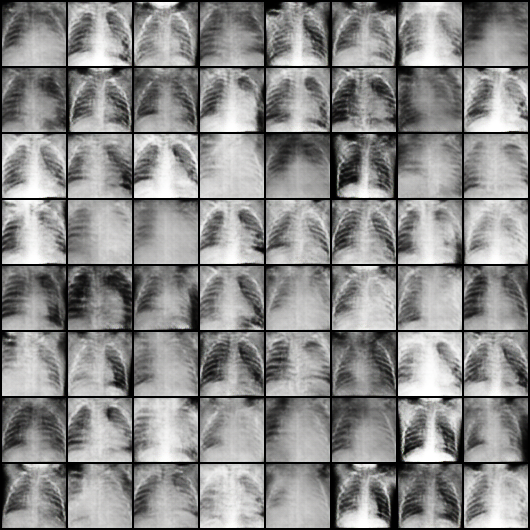

In [ ]:
Image('./generated/generated-images-0020.png')

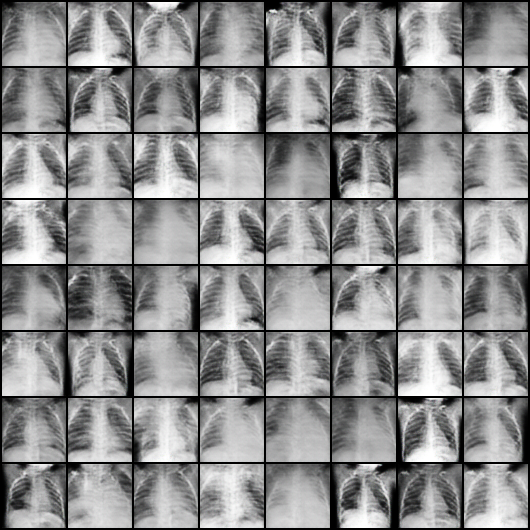

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

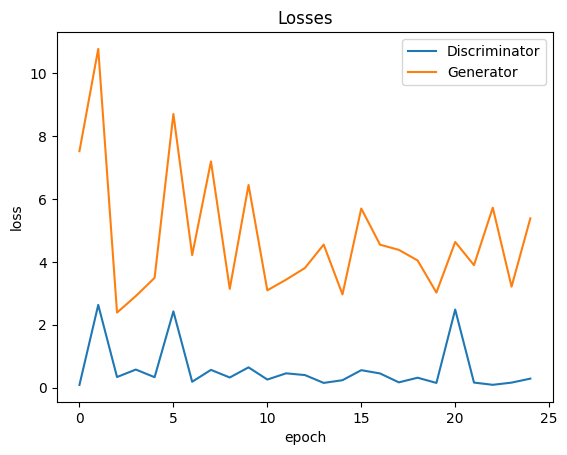

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

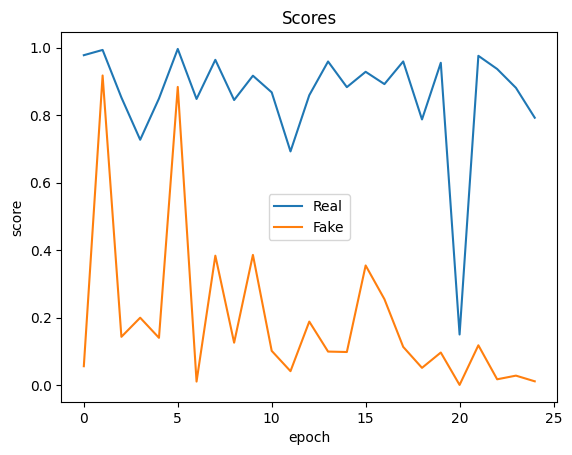

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');